In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import json
from PIL import Image

In [45]:
CWD = os.getcwd()
DATA_DIR = "bdd-sample"
BDD_IMAGES_TRAIN = os.path.join(CWD,"resources",DATA_DIR,"images","train")
BDD_IMAGES_TEST = os.path.join(CWD,"resources",DATA_DIR,"images","test")
BDD_LABELS_TRAIN = os.path.join(CWD,"resources",DATA_DIR,"labels","train")
BDD_LABELS_TEST = os.path.join(CWD,"resources",DATA_DIR,"labels","test")
BDD_SEGMENTED_TRAIN = os.path.join(CWD,"resources",DATA_DIR,"segmented","color_labels","train")
BDD_SEGMENTED_VAL = os.path.join(CWD,"resources",DATA_DIR,"segmented","color_labels","val")

In [48]:
# just change what these vars below equal to pull from diff sources
train_images_paths = sorted(os.listdir(BDD_IMAGES_TRAIN))
test_images_paths = sorted(os.listdir(BDD_IMAGES_TEST))

train_labels_paths = sorted(os.listdir(BDD_LABELS_TRAIN))
test_labels_paths = sorted(os.listdir(BDD_LABELS_TEST))

#seg_train_images_paths = sorted(os.listdir(BDD_SEGMENTED_TRAIN))
#seg_test_images_paths = sorted(os.listdir(BDD_SEGMENTED_VAL))

In [49]:
print(train_images_paths[0], train_labels_paths[0])
print(len(train_labels_paths),len(test_labels_paths))
#print(len(seg_train_images_paths),seg_train_images_paths[0])

000d4f89-3bcbe37a.jpg 000d4f89-3bcbe37a.json
1002 2002


## Load Images
Use Pillow cuz its easy, json.load()
Populate arrays containing image data and label data

In [60]:
def load_images(images_dir,images_paths):
    images=[]
    for i in range(len(images_paths)):
        try:
            path = os.path.join(images_dir,images_paths[i])
            img = Image.open(path)
            img_np = np.array(img)
            images.append(img_np)
        except Exception as e:
            print(f"Error loading image {images_paths[i]}: {e}")
    return np.array(images)

In [61]:
def load_labels(labels_dir,labels_paths):
    labels=[]
    for i in range(len(labels_paths)):
        with open(os.path.join(labels_dir,labels_paths[i]),"r") as file:
            parsed = json.load(file)
            labels.append(parsed)
    return labels

In [62]:
train_images = load_images(BDD_IMAGES_TRAIN,train_images_paths)
test_images = load_images(BDD_IMAGES_TEST,test_images_paths)
train_labels = load_labels(BDD_LABELS_TRAIN,train_labels_paths)
test_labels = load_labels(BDD_LABELS_TEST,test_labels_paths)

In [63]:
print(train_images[0])

[[[137 165 169]
  [137 165 169]
  [137 165 169]
  ...
  [ 51  51  49]
  [ 51  51  49]
  [ 51  51  49]]

 [[137 165 169]
  [137 165 169]
  [137 165 169]
  ...
  [ 58  58  56]
  [ 58  58  56]
  [ 58  58  56]]

 [[137 165 169]
  [137 165 169]
  [137 165 169]
  ...
  [ 62  62  60]
  [ 62  62  60]
  [ 62  62  60]]

 ...

 [[  4   4   4]
  [  4   4   4]
  [  4   4   4]
  ...
  [ 43  57  60]
  [ 43  57  60]
  [ 43  57  60]]

 [[  4   4   4]
  [  4   4   4]
  [  4   4   4]
  ...
  [ 43  57  60]
  [ 43  57  60]
  [ 43  57  60]]

 [[  4   4   4]
  [  4   4   4]
  [  4   4   4]
  ...
  [ 43  57  60]
  [ 43  57  60]
  [ 43  57  60]]]


## Work with images loaded

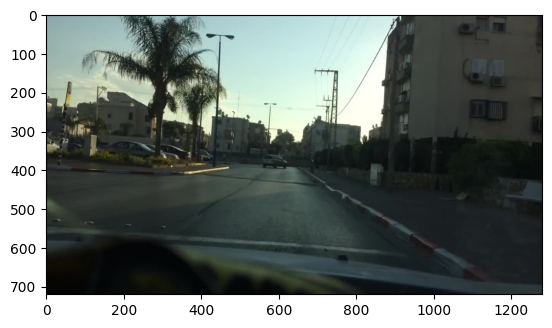

In [64]:
plt.figure()
plt.imshow(train_images[0])
plt.grid(False)
plt.show()